<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Transformer/TabTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured data learning with TabTransformer

**Description:** Using contextual embeddings for structured data classification.

## Introduction

This example demonstrates how to do structured data classification using
[TabTransformer](https://arxiv.org/abs/2012.06678), a deep tabular data modeling
architecture for supervised and semi-supervised learning.
The TabTransformer is built upon self-attention based Transformers.
The Transformer layers transform the embeddings of categorical features
into robust contextual embeddings to achieve higher predictive accuracy.

## Prepare the data

This example uses the
[United States Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/census+income)
provided by the
[UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).
The task is binary classification
to predict whether a person is likely to be making over USD 50,000 a year.

The dataset includes 48,842 instances with 14 input features: 5 numerical features and 9 categorical features.

First, let's load the dataset from the UCI Machine Learning Repository into a Pandas
DataFrame:

In [1]:
import pandas as pd

CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


Remove the first record (because it is not a valid data example) and a trailing 'dot' in the class labels.

In [18]:
test_data = test_data[1:].copy()
test_data.income_bracket = test_data.income_bracket.apply(
    lambda value: value.replace(".", "")
)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 2 to 16281
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16280 non-null  object 
 1   workclass       16280 non-null  object 
 2   fnlwgt          16280 non-null  float64
 3   education       16280 non-null  object 
 4   education_num   16280 non-null  float64
 5   marital_status  16280 non-null  object 
 6   occupation      16280 non-null  object 
 7   relationship    16280 non-null  object 
 8   race            16280 non-null  object 
 9   gender          16280 non-null  object 
 10  capital_gain    16280 non-null  float64
 11  capital_loss    16280 non-null  float64
 12  hours_per_week  16280 non-null  float64
 13  native_country  16280 non-null  object 
 14  income_bracket  16280 non-null  object 
dtypes: float64(5), object(10)
memory usage: 1.9+ MB


## Implement data reading pipeline

We define an function that converts features
and labels into a[`tf.data.Dataset`](https://www.tensorflow.org/guide/datasets)
for training or evaluation.

In [36]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

target_label_lookup = tf.keras.layers.StringLookup(
    vocabulary=train_data['income_bracket'].unique(),
    num_oov_indices=0
)

def prepare_example(X, y):
    y = {k: target_label_lookup(v) for k, v in y.items()}
    X.pop('fnlwgt')
    return X, y

def get_dataset(df, shuffle=False):
    X = {k: v.values for k, v in df.items() if k!='income_bracket'}
    y = {k: v.values for k, v in df.items() if k=='income_bracket'}
    ds = tf.data.Dataset.from_tensor_slices(tensors=(X, y)).cache()
    ds = ds.map(prepare_example)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size=128)

    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

ds_train = get_dataset(df=train_data, shuffle=True)
ds_train.element_spec

({'age': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'workclass': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'education': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'education_num': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'marital_status': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'occupation': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'relationship': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'race': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'gender': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'capital_gain': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'capital_loss': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'hours_per_week': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  'native_country': TensorSpec(shape=(None,), dtype=tf.string, name=None)},
 {'income_bracket': TensorSpec(shape=(None,), dtype=tf.int64, name=None)})

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

target_label_lookup = tf.keras.layers.StringLookup(
    vocabulary=train_data['income_bracket'].unique())

def prepare_example(features, target):
    target_index = target_label_lookup(target['income_bracket'])
    features.pop(WEIGHT_COLUMN_NAME)
    # weights are not used in this example, return None
    return features, target_index, None

lookup_dict = {}
for feature_name in CATEGORICAL_FEATURE_NAMES:
    vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
    # Create a lookup to convert a string values to an integer indices.
    # Since we are not using a mask token, and expecting any out of vocabulary
    # (oov) token, we set mask_token to None and num_oov_indices to 1.
    lookup = tf.keras.layers.StringLookup(
        vocabulary=vocabulary, mask_token=None, num_oov_indices=1
    )
    lookup_dict[feature_name] = lookup

def encode_categorical(batch_x, batch_y, weights):
    for feature_name in CATEGORICAL_FEATURE_NAMES:
        batch_x[feature_name] = lookup_dict[feature_name](batch_x[feature_name])

    return batch_x, batch_y, weights

def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = (
        tf.data.experimental.make_csv_dataset(
            file_pattern=csv_file_path,
            batch_size=batch_size,
            column_names=CSV_HEADER,
            column_defaults=COLUMN_DEFAULTS,
            label_name=TARGET_FEATURE_NAME,
            num_epochs=1,
            header=False,
            na_value="?",
            shuffle=shuffle
        )
        .map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False)
        .map(encode_categorical)
    )
    return dataset.cache()

lookup_dict

{'workclass': <StringLookup name=string_lookup_1, built=False>,
 'education': <StringLookup name=string_lookup_2, built=False>,
 'marital_status': <StringLookup name=string_lookup_3, built=False>,
 'occupation': <StringLookup name=string_lookup_4, built=False>,
 'relationship': <StringLookup name=string_lookup_5, built=False>,
 'race': <StringLookup name=string_lookup_6, built=False>,
 'gender': <StringLookup name=string_lookup_7, built=False>,
 'native_country': <StringLookup name=string_lookup_8, built=False>}

## Define dataset metadata

Here, we define the metadata of the dataset that will be useful for reading and parsing
the data into input features, and encoding the input features with respect to their types.

In [ ]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sorted(list(train_data["workclass"].unique())),
    "education": sorted(list(train_data["education"].unique())),
    "marital_status": sorted(list(train_data["marital_status"].unique())),
    "occupation": sorted(list(train_data["occupation"].unique())),
    "relationship": sorted(list(train_data["relationship"].unique())),
    "race": sorted(list(train_data["race"].unique())),
    "gender": sorted(list(train_data["gender"].unique())),
    "native_country": sorted(list(train_data["native_country"].unique())),
}
# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "fnlwgt"
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "income_bracket"
# A list of the labels of the target features.
TARGET_LABELS = [" <=50K", " >50K"]

FEATURE_NAMES

['age',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native_country']

## Configure the hyperparameters

The hyperparameters includes model architecture and training configurations.

In [ ]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 1

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [2, 1]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

## Implement a training and evaluation procedure

In [ ]:
import tensorflow as tf

def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):
    tf.keras.utils.set_random_seed(seed=42)
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(csv_file_path=train_data_file,
        batch_size=batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(csv_file_path=test_data_file,
        batch_size=batch_size)

    print("Start training the model...")
    history = model.fit(
        x=train_dataset, epochs=num_epochs, validation_data=validation_dataset,
        verbose=False
    )
    print("Model training finished")

    _, accuracy = model.evaluate(x=validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

## Create model inputs

Now, define the inputs for the models as a dictionary, where the key is the feature name,
and the value is a `keras.layers.Input` tensor with the corresponding feature shape
and data type.

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = tf.keras.Input(
                name=feature_name, shape=(), dtype="float32"
            )
        else:
            inputs[feature_name] = tf.keras.Input(
                name=feature_name, shape=(), dtype="int32"
            )
    return inputs

create_model_inputs()

{'age': <KerasTensor shape=(None,), dtype=float32, sparse=False, ragged=False, name=age>,
 'education_num': <KerasTensor shape=(None,), dtype=float32, sparse=False, ragged=False, name=education_num>,
 'capital_gain': <KerasTensor shape=(None,), dtype=float32, sparse=False, ragged=False, name=capital_gain>,
 'capital_loss': <KerasTensor shape=(None,), dtype=float32, sparse=False, ragged=False, name=capital_loss>,
 'hours_per_week': <KerasTensor shape=(None,), dtype=float32, sparse=False, ragged=False, name=hours_per_week>,
 'workclass': <KerasTensor shape=(None,), dtype=int32, sparse=False, ragged=False, name=workclass>,
 'education': <KerasTensor shape=(None,), dtype=int32, sparse=False, ragged=False, name=education>,
 'marital_status': <KerasTensor shape=(None,), dtype=int32, sparse=False, ragged=False, name=marital_status>,
 'occupation': <KerasTensor shape=(None,), dtype=int32, sparse=False, ragged=False, name=occupation>,
 'relationship': <KerasTensor shape=(None,), dtype=int32, sp

## Encode features

The `encode_inputs` method returns `encoded_categorical_feature_list` and `numerical_feature_list`.
We encode the categorical features as embeddings, using a fixed `embedding_dims` for all the features,
regardless their vocabulary sizes. This is required for the Transformer model.

In [ ]:
import tensorflow as tf

def encode_inputs(inputs, embedding_dims):
    tf.keras.utils.set_random_seed(seed=42)
    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # The categorical features are already encoded to integer indices by the dataset pipeline.
            categorical_indices = inputs[feature_name]

            # Create an embedding layer with the specified dimensions.
            embedding = tf.keras.layers.Embedding(
                input_dim=len(vocabulary) + 1, output_dim=embedding_dims, name=f"embedding_{feature_name}" # Add 1 to input_dim for OOV
            )

            # Convert the index values to embedding representations.
            print(f"Feature: {feature_name}, Input values type: {categorical_indices.dtype}, Input values shape: {categorical_indices.shape}")
            print(f"Feature: {feature_name}, Vocabulary size: {len(vocabulary)}")
            encoded_categorical_feature = embedding(categorical_indices)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:
            # Use the numerical features as-is.
            numerical_feature = tf.keras.ops.expand_dims(x=inputs[feature_name], axis=-1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

## Implement an MLP block

In [ ]:
import tensorflow as tf

def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    tf.keras.utils.set_random_seed(seed=42)
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer())
        mlp_layers.append(tf.keras.layers.Dense(units=units, activation=activation))
        mlp_layers.append(tf.keras.layers.Dropout(rate=dropout_rate))

    return tf.keras.Sequential(mlp_layers, name=name)

## Experiment 1: a baseline model

In the first experiment, we create a simple multi-layer feed-forward network.

Feature: workclass, Input values type: int32, Input values shape: (None,)
Feature: workclass, Vocabulary size: 9
Feature: education, Input values type: int32, Input values shape: (None,)
Feature: education, Vocabulary size: 16
Feature: marital_status, Input values type: int32, Input values shape: (None,)
Feature: marital_status, Vocabulary size: 7
Feature: occupation, Input values type: int32, Input values shape: (None,)
Feature: occupation, Vocabulary size: 15
Feature: relationship, Input values type: int32, Input values shape: (None,)
Feature: relationship, Vocabulary size: 6
Feature: race, Input values type: int32, Input values shape: (None,)
Feature: race, Vocabulary size: 5
Feature: gender, Input values type: int32, Input values shape: (None,)
Feature: gender, Vocabulary size: 2
Feature: native_country, Input values type: int32, Input values shape: (None,)
Feature: native_country, Vocabulary size: 42
Total model weights: 110821


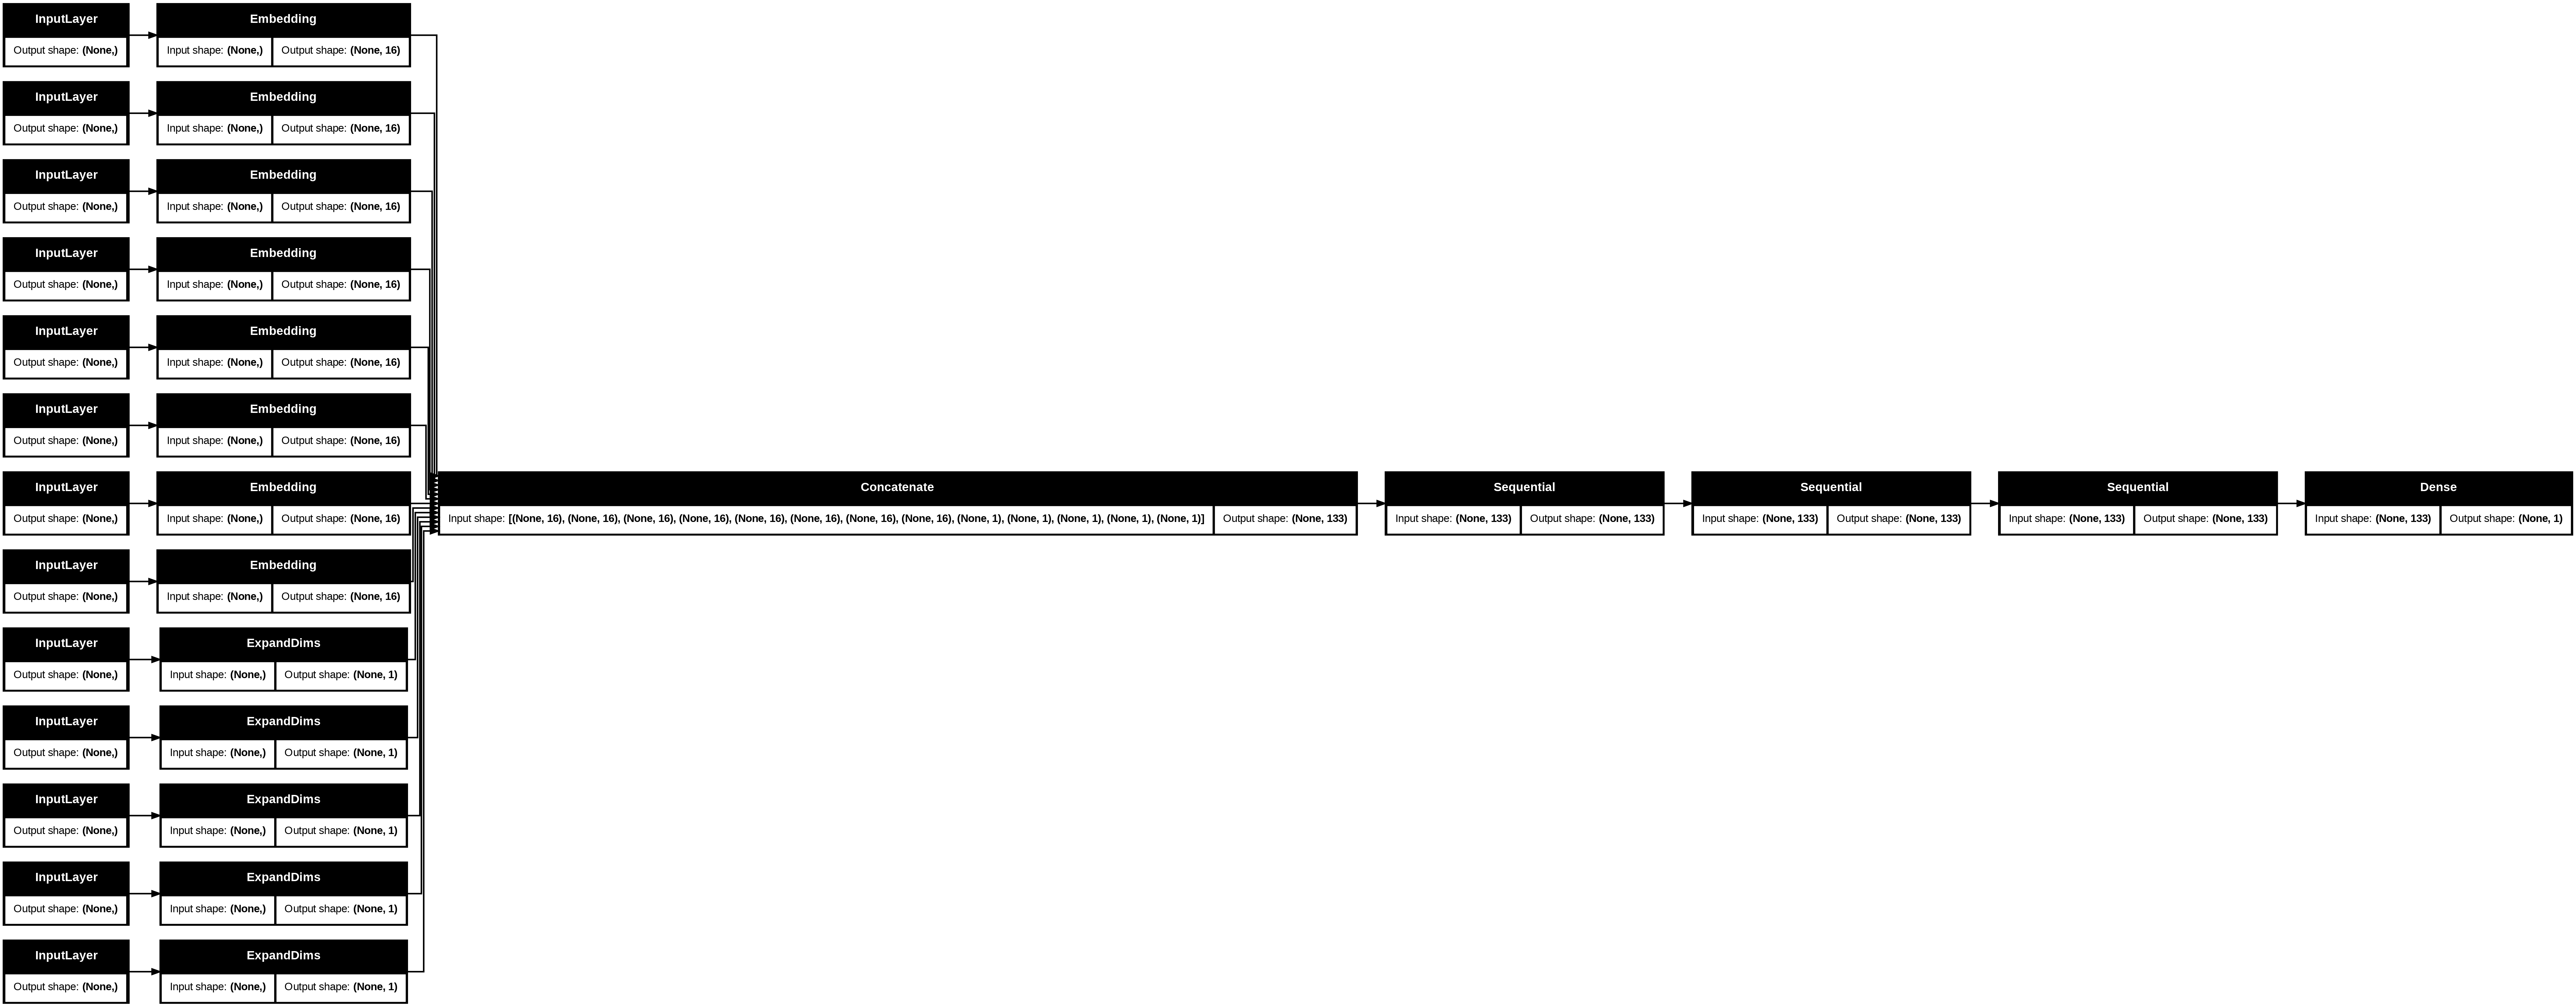

In [ ]:
import tensorflow as tf

def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    tf.keras.utils.set_random_seed(seed=42)
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs=inputs, embedding_dims=embedding_dims
    )
    # Concatenate all features.
    features = tf.keras.layers.concatenate(
        inputs=encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=tf.keras.activations.gelu,
            normalization_layer=tf.keras.layers.LayerNormalization,
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=tf.keras.activations.selu,
        normalization_layer=tf.keras.layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = tf.keras.layers.Dense(name="sigmoid", units=1,
        activation=tf.keras.activations.sigmoid)(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
tf.keras.utils.plot_model(model=baseline_model, show_shapes=True, rankdir="LR")

Let's train and evaluate the baseline model:

In [ ]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE
)

The baseline linear model achieves ~81% validation accuracy.

## Experiment 2: TabTransformer

The TabTransformer architecture works as follows:

1. All the categorical features are encoded as embeddings, using the same `embedding_dims`.
This means that each value in each categorical feature will have its own embedding vector.
2. A column embedding, one embedding vector for each categorical feature, is added (point-wise) to the categorical feature embedding.
3. The embedded categorical features are fed into a stack of Transformer blocks.
Each Transformer block consists of a multi-head self-attention layer followed by a feed-forward layer.
3. The outputs of the final Transformer layer, which are the *contextual embeddings* of the categorical features,
are concatenated with the input numerical features, and fed into a final MLP block.
4. A `softmax` classifer is applied at the end of the model.

The [paper](https://arxiv.org/abs/2012.06678) discusses both addition and concatenation of the column embedding in the
*Appendix: Experiment and Model Details* section.
The architecture of TabTransformer is shown below, as presented in the paper.

<img src="https://raw.githubusercontent.com/keras-team/keras-io/master/examples/structured_data/img/tabtransformer/tabtransformer.png" width="500"/>

In [ ]:

def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = ops.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = ops.arange(start=0, stop=num_columns, step=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(
                layers.LayerNormalization, epsilon=1e-6
            ),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

Let's train and evaluate the TabTransformer model:

In [ ]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

The TabTransformer model achieves ~85% validation accuracy.
Note that, with the default parameter configurations, both the baseline and the TabTransformer
have similar number of trainable weights: 109,895 and 87,745 respectively, and both use the same training hyperparameters.

## Conclusion

TabTransformer significantly outperforms MLP and recent
deep networks for tabular data while matching the performance of tree-based ensemble models.
TabTransformer can be learned in end-to-end supervised training using labeled examples.
For a scenario where there are a few labeled examples and a large number of unlabeled
examples, a pre-training procedure can be employed to train the Transformer layers using unlabeled data.
This is followed by fine-tuning of the pre-trained Transformer layers along with
the top MLP layer using the labeled data.
